In [22]:
import sys
import os
import numpy as np
import pygod
from pygod.utils import load_data
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
import torch_sparse
from torch_sparse import SparseTensor
from typing import List
from sklearn.metrics import roc_auc_score
from gad_adversarial_robustness.utils.graph_utils import prepare_graph, get_n_anomaly_indexes, load_anomaly_detection_dataset, get_anomaly_indexes
from gad_adversarial_robustness.poison.greedy import multiple_AS, poison_attack

import argparse
import scipy.sparse as sp
from scipy.sparse import coo_matrix
from torch_geometric.utils.convert import from_scipy_sparse_matrix
from torch_geometric.utils import to_undirected

# --------- related to dataset import
from pygod.generator import gen_contextual_outlier, gen_structural_outlier
from torch_geometric.datasets import AttributedGraphDataset
from gad_adversarial_robustness.gad.OddBall_vs_DOMININANT import get_OddBall_AS

# --------- jaccard
from gad_adversarial_robustness.gad.dominant.dominant_cuda import Dominant
from gad_adversarial_robustness.gad.dominant.dominant_cuda_Jaccard_similarity import Dominant as DominantJaccard

# --------- setup
import yaml

In [23]:
# 20_budget_J_0.01_FB_gradmax_edge_index.pt
# 50_budget_J_0.01_FB_gradmax_edge_index_poisonVSnoPOison.pt
# 50_budget_J_0.02_FB_gradmax_edge_index_poisonVSnoPOison.pt
# 100_budget_CLIQUE_5_FB_gradmax_edge_index.pt

#   load data from save: T/F?
PRELOADED_EDGE_INDEX = True
#   file to save edge index to:
EDGE_INDEX_PT = "100_budget_CLIQUE_5_FB_gradmax_edge_index.pt"
#   file to load edge index from
EDGE_INDEX_SAVE_FILE_SAVE_LOAD = '100_budget_CLIQUE_5_FB_gradmax_edge_index.pt'

# Poison Constants
SEED = 123
NUM_NODES_PER_CLIQUE = 5 # (perhaps reduce this value for a faster run)
BUDGET = 100
TOP_K = 10
SAMPLE_MODE = 'top' # 'top', 'lowest', 'normal'

# Jaccard
JACCARD = 0.05

In [24]:
script_dir = os.path.abspath('')
yaml_path = os.path.join(script_dir, '..', 'configs', 'dominant_config.yaml')
with open(yaml_path) as file:
        config = yaml.safe_load(file)

#### Import Data

In [25]:
# ------- datasets: 
data_name = ["Cora", "Wiki", "Facebook", "Blogcatalog"] # blogcataog not an option yet
string = data_name[2]

dataset = AttributedGraphDataset(root = "data/"+string, name = string)
data = dataset[0]

data.edge_index = to_undirected(data.edge_index) # IMPORTANT: makes the graph undirected, which is necessary 

clean_data = data.clone() # save for later use

# ------- inject dataset through pygod:
seed = SEED
num_nodes_to_inject = round(data.num_nodes * 0.05)
num_nodes_per_clique = NUM_NODES_PER_CLIQUE
num_cliques = (num_nodes_to_inject // 2) // num_nodes_per_clique
num_contextual_outliers = num_nodes_to_inject - num_cliques * num_nodes_per_clique

data, ya = gen_contextual_outlier(data, n = num_contextual_outliers, k = 50, seed = seed) 
#   n (int) – Number of nodes converting to outliers.
#   k (int) – Number of candidate nodes for each outlier node.

data, ys = gen_structural_outlier(data, m = num_nodes_per_clique, n = num_cliques, seed = seed, p=0.2)
#   m (int) - Number nodes in the outlier cliques.
#   n (int) - Number of outlier clique

data.y = torch.logical_or(ys, ya).long() # where ys = y structural and ya = y attribute


unpoisoned_data = data.clone()

# below is not really used???
y_binary: List[int] = data.y.bool()
anomaly_list = np.where(y_binary == True)[0]  # Used for list for which nodes to hide
print(f"\nAnomaly list: {anomaly_list}\n")


Anomaly list: [  40   68   83   90  114  163  173  239  251  324  348  359  377  417
  468  472  562  703  709  777  824  858  901  932 1021 1048 1062 1083
 1139 1148 1211 1302 1340 1368 1404 1455 1493 1497 1513 1589 1618 1627
 1711 1746 1748 1871 1880 1886 1903 1944 1945 1947 1952 1954 1995 2107
 2128 2161 2209 2212 2243 2249 2262 2272 2335 2413 2568 2585 2604 2616
 2653 2675 2718 2813 2818 2848 2872 3003 3033 3066 3104 3236 3311 3345
 3440 3453 3476 3528 3546 3650 3665 3734 3759 3767 3779 3829 3851 3880
 3894 3950 3960 3993]



In [26]:
print(dataset[0])

# print(f'Edges are directed: {dataset.is_directed()}')
# print(f'Graph has isolated nodes: {dataset.has_isolated_nodes()}')
print(f'Graph has loops: {dataset[0].has_self_loops()}')

print('------------')
print(f'Number of graphs: {len(dataset[0])}')
print(f'Number of features: {dataset[0].num_features}')

Data(x=[4039, 1283], edge_index=[2, 88234], y=[4039, 193])
Graph has loops: False
------------
Number of graphs: 3
Number of features: 1283


In [27]:
count=0
for row in clean_data.y:
    for element in row:
        if int(element) != 0:
            count+=1

print(count)

4426


In [28]:
print('poisoned data:   ', data)
print('clean data:      ', clean_data)
print('unpoisoned data: ', unpoisoned_data)
print('edge_index diff: ', len(data.edge_index[1]) - len(clean_data.edge_index[1]))
# print('edge_index diff poison vs. unpoisoned: ', len(data.edge_index[1]) - len(unpoisoned_data.edge_index[1]))

poisoned data:    Data(x=[4039, 1283], edge_index=[2, 177188], y=[4039])
clean data:       Data(x=[4039, 1283], edge_index=[2, 176468], y=[4039, 193])
unpoisoned data:  Data(x=[4039, 1283], edge_index=[2, 177188], y=[4039])
edge_index diff:  720


#### adj matrix from edge_index

In [29]:
# -----> to obtain the adj matrix from edge_index tensor 
_, adj, _ = prepare_graph(data)

data.adj = adj.to_dense()

tensor([1., 1., 1.,  ..., 1., 1., 1.])
node_attrs
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
adj
SparseTensor(row=tensor([   0,    0,    0,  ..., 4038, 4038, 4038]),
             col=tensor([   1,    2,    3,  ..., 4023, 4027, 4031]),
             val=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
             size=(4039, 4039), nnz=177176, density=1.09%)
labels
tensor([0, 0, 0,  ..., 0, 0, 0])


### Posion (compute OR load in poisoned data)

In [30]:
if PRELOADED_EDGE_INDEX is False :
    # truth, of type int list, is instantiated to the T/F labels indicating whether a node is an anomalous node
    truth: List[int] = data.y.bool()
    print('truth: ', truth)

    A = np.array(data.adj)

    print("Create poison compatible adjacency matrix...") # based on code from: https://github.com/zhuyulin-tony/BinarizedAttack/blob/main/src/Greedy.py
    triple = []
    for i in range(data.num_nodes): # for all nodes...
        for j in range(i + 1, data.num_nodes):
            triple.append([i, j, A[i,j]])  # Fill with 0, then insert actual after
    triple = np.array(triple) # convert to numpy array

    print('tripple: ', triple)

    # ------- Identify Anomalous Nodes 
    # The nodes we try reduce the "Active Subnetwork" score for (i.e. disguise anonomalous nodes)
    target_node_lst = get_n_anomaly_indexes(truth, TOP_K) # the indexes of the anomalies (999 is just a flag, if not 999 then it gets from 0 to n anomaly indexes)

    # 2nd ver ----- utilizing oddball to get terget list
    target_list_as = get_OddBall_AS(data=data, device=config['model']['device'])
    target_list_as = np.array(target_list_as)
    label = torch.Tensor(data.y.bool()).to(config['model']['device'])
    labels_np = label.cpu().detach().numpy()
    # print("ALL:")
    # get_anomalies_with_label_1(target_list_as, labels_np)
    print("NOT ALL:")
    target_list = get_anomaly_indexes(target_list_as, labels_np, TOP_K, method=SAMPLE_MODE, print_scores=True)

    print(f"\nAnomaly list: {target_list}\n")

    # ------- Making Model
    multiple_AS_model = multiple_AS(target_lst = target_list, n_node = data.num_nodes, device = 'cpu')

    # ------- Attack (GradMaxSearch, i.e. the greedy attack)
    adj_adversary, _, _ = poison_attack(multiple_AS_model, triple, BUDGET) # returns modified/ poisoned adj matrix | budget is the amount of edges to change

    # -------- post-attack processing --> i.e. "Converting to compatible tensor"
    edge_index = torch.tensor([[],[]]) # Create new Edge Index

    # Transpose it to make shape compatible
    transposed_adj_adversary = torch.transpose(adj_adversary, 0, 1)

    for i in range(len(adj_adversary)):
        if(adj_adversary[i][2] != 0):   # If edge value is NOT 0 (0 meaning no edge)
            # Add edge to edge index, choosing first 2 elements (edges), and then the ith edge
            edge_index = torch.cat((edge_index, transposed_adj_adversary[:2, i:i+1]), -1)

            # Dataset uses edges both ways so add reverse edge as well
            edge_index = torch.cat((edge_index, torch.flip(transposed_adj_adversary[:2, i:i+1], dims=[0])), -1)

    edge_index = edge_index.type(torch.int64)
    data.edge_index = edge_index # assign to dataset obj

    # # print out the final AS scores after poison
    # scores = np.array(multiple_AS_model.score)
    # labels = np.array(multiple_AS_model.label)

    # valid_indices = torch.where(torch.tensor(labels) == 1)[0]
    # valid_indices = valid_indices.detach().cpu().numpy()

    # sorted_indices = sorted(valid_indices, key=lambda i: scores[i], reverse=True)

    # selected_indices = sorted_indices[:TOP_K]

    # # Print anomaly scores for the top K indices
    # print("Anomaly scores for top K indices with label = 1:")
    # for idx in selected_indices:
    #     print("Index:", idx, "| Anomaly Score:", scores[idx])

    # ---- SAVE the edge index data: 
    torch.save(data.edge_index, EDGE_INDEX_PT)
else :
    # load data
    data.edge_index = torch.load(EDGE_INDEX_SAVE_FILE_SAVE_LOAD)

In [ ]:
if PRELOADED_EDGE_INDEX is False :
    # print out the final AS scores after poison
    scores = np.array(multiple_AS_model.score)
    labels = np.array(multiple_AS_model.label)

    valid_indices = torch.where(torch.tensor(labels) == 1)[0]
    valid_indices = valid_indices.detach().cpu().numpy()

    sorted_indices = sorted(valid_indices, key=lambda i: scores[i], reverse=True)

    selected_indices = sorted_indices[:TOP_K]

    # Print anomaly scores for the top K indices
    print("Anomaly scores for top K indices with label = 1:")
    for idx in selected_indices:
        print("Index:", idx, "| Anomaly Score:", scores[idx])

In [31]:
# print(f"\nAnomaly list: {target_list}\n")


In [32]:
# target_node_lst

In [55]:
# scores = np.array(model.score)
# labels = np.array(model.label)

# valid_indices = torch.where(torch.tensor(labels) == 1)[0]
# valid_indices = valid_indices.detach().cpu().numpy()

# sorted_indices = sorted(valid_indices, key=lambda i: scores[i], reverse=True)

# selected_indices = sorted_indices[:TOP_K]

# # Print anomaly scores for the top K indices
# print("Anomaly scores for top K indices with label = 1:")
# for idx in selected_indices:
#     print("Index:", idx, "| Anomaly Score:", scores[idx])
    

Anomaly scores for top K indices with label = 1:
Index: 2335 | Anomaly Score: 5.6895413
Index: 1048 | Anomaly Score: 5.643447
Index: 2616 | Anomaly Score: 5.3561115
Index: 1871 | Anomaly Score: 5.325048
Index: 1340 | Anomaly Score: 5.2854257
Index: 703 | Anomaly Score: 5.1944036
Index: 1021 | Anomaly Score: 5.1873693
Index: 2161 | Anomaly Score: 5.179742
Index: 348 | Anomaly Score: 5.175001
Index: 3345 | Anomaly Score: 5.171911


In [33]:
print('poisoned data:   ', data)
print('clean data:      ', clean_data)
print('unpoisoned data: ', unpoisoned_data)
print('edge_index diff: ', len(data.edge_index[1]) - len(clean_data.edge_index[1]))
print('edge_index diff: ', len(data.edge_index[1]) - len(unpoisoned_data.edge_index[1]))

poisoned data:    Data(x=[4039, 1283], edge_index=[2, 177076], y=[4039], adj=[4039, 4039])
clean data:       Data(x=[4039, 1283], edge_index=[2, 176468], y=[4039, 193])
unpoisoned data:  Data(x=[4039, 1283], edge_index=[2, 177188], y=[4039])
edge_index diff:  608
edge_index diff:  -112


# GAD: DOMINANT JACCARD SIMILARITY

In [34]:
#### DELETE CELL AFTER DEBUGGING --> move changes to utils #####
from gad_adversarial_robustness.utils.graph_utils import to_dense_adj, normalize_adj
def load_anomaly_detection_dataset(dataset, datadir='data'):
    # import dataset and extract its parts
    #dataset = load_data("inj_cora")
    edge_index = dataset.edge_index
    adj = to_dense_adj(edge_index)[0].detach().cpu().numpy() # size of adj = 16313521
    print('adj size after to_dense_adj call: ', adj.size)
    
    feat= dataset.x.detach().cpu().numpy()
    # remember to use .bool() if the dataset is an injected dataset, to enable binary labels.
    # TODO: handle the case where we inject ourselves
    print('dataset.y.size : ', len(dataset.y)) # 4039
    print('detached y: ', len(dataset.y.bool().detach().cpu().numpy())) # 4039

    truth = dataset.y.bool().detach().cpu().numpy()
    # truth = truth.flatten() # len: 779527
    

    adj_norm = normalize_adj(adj + sp.eye(adj.shape[0]))
    adj_norm = adj_norm.toarray()
    adj = adj + np.eye(adj.shape[0])
    return adj_norm, feat, truth, adj

### regular Dominant on CLEAN and POISONED data

In [35]:
print("DOMINANT on Unpoisoned data:")
adj, attrs, label, adj_label = load_anomaly_detection_dataset(unpoisoned_data)
edge_index = torch.LongTensor(np.array(sp.coo_matrix(adj).nonzero()))
adj_label = torch.FloatTensor(adj_label)
attrs = torch.FloatTensor(attrs)

dominant_model_unpoisoned = Dominant(feat_size=attrs.size(1), hidden_size=config['model']['hidden_dim'], dropout=config['model']['dropout'],
                    device='cpu', edge_index=edge_index, adj_label=adj_label, attrs=attrs, label=label)

dominant_model_unpoisoned.fit(config, new_edge_index=edge_index, attrs=attrs,verbose=True, top_k=TOP_K)

# retrieve stats
M1_feature_loss_arr = dominant_model_unpoisoned.feature_loss_arr
M1_structure_loss_arr = dominant_model_unpoisoned.structure_loss_arr

M1_loss_arr = dominant_model_unpoisoned.loss_arr

M1_aucroc_arr = dominant_model_unpoisoned.aucroc_arr
M1_aucroc_norm = dominant_model_unpoisoned.aucroc_norm_arr

DOMINANT on Unpoisoned data:
adj size after to_dense_adj call:  16313521
dataset.y.size :  4039
detached y:  4039
Fitting on edge index of shape:  torch.Size([2, 185254])
Epoch: 0000, train_loss=3.55299, train/struct_loss=6.65841, train/feat_loss=2.77664
Epoch: 0000, roc-auc: 0.9032457280600836
Epoch: 0001, train_loss=3.44704, train/struct_loss=6.17986, train/feat_loss=2.76383
Epoch: 0002, train_loss=3.42877, train/struct_loss=6.14676, train/feat_loss=2.74927
Epoch: 0003, train_loss=3.43396, train/struct_loss=6.25315, train/feat_loss=2.72917
Epoch: 0004, train_loss=3.39725, train/struct_loss=6.13303, train/feat_loss=2.71330
Epoch: 0005, train_loss=3.38311, train/struct_loss=6.13110, train/feat_loss=2.69611
Epoch: 0006, train_loss=3.36475, train/struct_loss=6.12838, train/feat_loss=2.67385
Epoch: 0007, train_loss=3.33781, train/struct_loss=6.10401, train/feat_loss=2.64627
Epoch: 0008, train_loss=3.31259, train/struct_loss=6.10708, train/feat_loss=2.61396
Epoch: 0009, train_loss=3.28173,

In [36]:
print("DOMINANT on POISONED data:")
# dataset = data
adj, attrs, label, adj_label = load_anomaly_detection_dataset(data)
edge_index = torch.LongTensor(np.array(sp.coo_matrix(adj).nonzero()))
adj_label = torch.FloatTensor(adj_label)
attrs = torch.FloatTensor(attrs)

dominant_model_poisoned = Dominant(feat_size=attrs.size(1), hidden_size=config['model']['hidden_dim'], dropout=config['model']['dropout'],
                    device='cpu', edge_index=edge_index, adj_label=adj_label, attrs=attrs, label=label)

dominant_model_poisoned.fit(config, new_edge_index=edge_index, attrs=attrs, verbose = True, top_k=TOP_K)

# retrieve stats
M2_feature_loss_arr = dominant_model_poisoned.feature_loss_arr
M2_structure_loss_arr = dominant_model_poisoned.structure_loss_arr

M2_loss_arr = dominant_model_poisoned.loss_arr

M2_aucroc_arr = dominant_model_poisoned.aucroc_arr
M2_aucroc_norm = dominant_model_poisoned.aucroc_norm_arr

DOMINANT on POISONED data:
adj size after to_dense_adj call:  16313521
dataset.y.size :  4039
detached y:  4039
Fitting on edge index of shape:  torch.Size([2, 185154])
Epoch: 0000, train_loss=3.46196, train/struct_loss=6.21652, train/feat_loss=2.77331
Epoch: 0000, roc-auc: 0.9054196735844452
Epoch: 0001, train_loss=3.43507, train/struct_loss=6.14022, train/feat_loss=2.75879
Epoch: 0002, train_loss=3.44527, train/struct_loss=6.28440, train/feat_loss=2.73549
Epoch: 0003, train_loss=3.39865, train/struct_loss=6.13382, train/feat_loss=2.71486
Epoch: 0004, train_loss=3.38007, train/struct_loss=6.14378, train/feat_loss=2.68914
Epoch: 0005, train_loss=3.34972, train/struct_loss=6.13283, train/feat_loss=2.65395
Epoch: 0006, train_loss=3.31718, train/struct_loss=6.14458, train/feat_loss=2.61032
Epoch: 0007, train_loss=3.27597, train/struct_loss=6.10550, train/feat_loss=2.56859
Epoch: 0008, train_loss=3.23247, train/struct_loss=6.08002, train/feat_loss=2.52058
Epoch: 0009, train_loss=3.18935, t

### Dominant Jaccard Similarity on poisoned data

In [37]:
jaccard_threshold = JACCARD

print("DOMINANT modified w/ Jaccard on Unpoisoned data:")
adj, _, _, adj_label = load_anomaly_detection_dataset(unpoisoned_data, config['model']['device'])

#edge_index = torch.LongTensor(np.array(sp.coo_matrix(adj).nonzero()))
adj_label = torch.FloatTensor(adj_label).to(config['model']['device'])
#attrs = torch.FloatTensor(attrs)

edge_index = unpoisoned_data.edge_index.to(config['model']['device'])
label = torch.Tensor(unpoisoned_data.y.bool()).to(config['model']['device'])
attrs = unpoisoned_data.x.to(config['model']['device'])

dominant_jaccard_model_unpoisoned = DominantJaccard(feat_size=attrs.size(1), hidden_size=config['model']['hidden_dim'], dropout=config['model']['dropout'],
                    device=config['model']['device'], edge_index=edge_index, adj_label=adj_label, attrs=attrs, label=label, adj=adj)
dominant_jaccard_model_unpoisoned.to(config['model']['device'])
dominant_jaccard_model_unpoisoned.fit(config, threshold=jaccard_threshold, verbose=True, top_k=TOP_K)

# retrieve stats
M3_feature_loss_arr = dominant_jaccard_model_unpoisoned.feature_loss_arr
M3_structure_loss_arr = dominant_jaccard_model_unpoisoned.structure_loss_arr

M3_loss_arr = dominant_jaccard_model_unpoisoned.loss_arr

M3_aucroc_arr = dominant_jaccard_model_unpoisoned.aucroc_arr
M3_aucroc_norm = dominant_jaccard_model_unpoisoned.aucroc_norm_arr

DOMINANT modified w/ Jaccard on Unpoisoned data:
adj size after to_dense_adj call:  16313521
dataset.y.size :  4039
detached y:  4039
count of avoided zero division: ------------------------------- 8
removed 2134 edges in the original graph


d:\karenscode\dat6_gad\aau-dat6-poison-gad\gad_adversarial_robustness\gad\GCN_Jaccard.py:356: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:607.)
  return torch.sparse.FloatTensor(sparseconcat.t(),sparsedata,torch.Size(sparse_mx.shape))
d:\karenscode\dat6_gad\aau-dat6-poison-gad\gad_adversarial_robustness\gad\GCN_Jaccard.py:390: RuntimeWarning: divide by zero encountered in power
  r_inv = np.power(rowsum, -1/2).flatten()


Epoch: 0000, train_loss=3.39654, train/struct_loss=5.87316, train/feat_loss=2.77738
Epoch: 0000, roc-auc: 0.9016943328004303
Top 10 highest anomaly scores' node IDs and scores:
Epoch: 0001, train_loss=3.37728, train/struct_loss=5.83910, train/feat_loss=2.76182
Epoch: 0002, train_loss=3.38948, train/struct_loss=5.97700, train/feat_loss=2.74260
Epoch: 0003, train_loss=3.34383, train/struct_loss=5.81201, train/feat_loss=2.72679
Epoch: 0004, train_loss=3.32250, train/struct_loss=5.80002, train/feat_loss=2.70313
Epoch: 0005, train_loss=3.29182, train/struct_loss=5.78171, train/feat_loss=2.66934
Epoch: 0006, train_loss=3.24962, train/struct_loss=5.72238, train/feat_loss=2.63143
Epoch: 0007, train_loss=3.20218, train/struct_loss=5.65672, train/feat_loss=2.58855
Epoch: 0008, train_loss=3.15347, train/struct_loss=5.59684, train/feat_loss=2.54263
Epoch: 0009, train_loss=3.10969, train/struct_loss=5.55533, train/feat_loss=2.49828
Epoch: 0010, train_loss=3.07618, train/struct_loss=5.53726, train/f

In [38]:
print("DOMINANT modified w/ Jaccard on POISONED data:")
adj, _, _, adj_label = load_anomaly_detection_dataset(data, config['model']['device'])
#edge_index = torch.LongTensor(np.array(sp.coo_matrix(adj).nonzero()))
adj_label = torch.FloatTensor(adj_label).to(config['model']['device'])
#attrs = torch.FloatTensor(attrs)

edge_index = data.edge_index.to(config['model']['device'])
label = torch.Tensor(data.y.bool()).to(config['model']['device'])
attrs = data.x.to(config['model']['device'])

dominant_jaccard_model_poisoned = DominantJaccard(feat_size=attrs.size(1), hidden_size=config['model']['hidden_dim'], dropout=config['model']['dropout'],
                    device=config['model']['device'], edge_index=edge_index, adj_label=adj_label, attrs=attrs, label=label, adj=adj)
dominant_jaccard_model_poisoned.to(config['model']['device'])
dominant_jaccard_model_poisoned.fit(config, threshold=jaccard_threshold, verbose=True, top_k=TOP_K)

# retrieve stats
M4_feature_loss_arr = dominant_jaccard_model_poisoned.feature_loss_arr
M4_structure_loss_arr = dominant_jaccard_model_poisoned.structure_loss_arr

M4_loss_arr = dominant_jaccard_model_poisoned.loss_arr

M4_aucroc_arr = dominant_jaccard_model_poisoned.aucroc_arr
M4_aucroc_norm = dominant_jaccard_model_poisoned.aucroc_norm_arr

DOMINANT modified w/ Jaccard on POISONED data:
adj size after to_dense_adj call:  16313521
dataset.y.size :  4039
detached y:  4039
count of avoided zero division: ------------------------------- 8
removed 2132 edges in the original graph


d:\karenscode\dat6_gad\aau-dat6-poison-gad\gad_adversarial_robustness\gad\GCN_Jaccard.py:390: RuntimeWarning: divide by zero encountered in power
  r_inv = np.power(rowsum, -1/2).flatten()


Epoch: 0000, train_loss=3.39759, train/struct_loss=5.88294, train/feat_loss=2.77626
Epoch: 0000, roc-auc: 0.9000557805037179
Top 10 highest anomaly scores' node IDs and scores:
Epoch: 0001, train_loss=3.38272, train/struct_loss=5.85715, train/feat_loss=2.76411
Epoch: 0002, train_loss=3.36275, train/struct_loss=5.82622, train/feat_loss=2.74688
Epoch: 0003, train_loss=3.35598, train/struct_loss=5.88923, train/feat_loss=2.72266
Epoch: 0004, train_loss=3.32339, train/struct_loss=5.79510, train/feat_loss=2.70547
Epoch: 0005, train_loss=3.30112, train/struct_loss=5.77679, train/feat_loss=2.68220
Epoch: 0006, train_loss=3.26693, train/struct_loss=5.72880, train/feat_loss=2.65146
Epoch: 0007, train_loss=3.22860, train/struct_loss=5.69129, train/feat_loss=2.61293
Epoch: 0008, train_loss=3.17770, train/struct_loss=5.58794, train/feat_loss=2.57514
Epoch: 0009, train_loss=3.13397, train/struct_loss=5.53084, train/feat_loss=2.53476
Epoch: 0010, train_loss=3.09789, train/struct_loss=5.51949, train/f

In [39]:
M4_aucroc_arr


[0.9000557805037179,
 0.9356407536344483,
 0.9465627754784922,
 0.9546883015334658,
 0.9633990248372654,
 0.9646416351656233,
 0.9662727168591593,
 0.9679087789548128,
 0.9689247809868168,
 0.9695323900451722,
 0.9707849611777656]

## Plotting 

In [42]:
import matplotlib.pyplot as plt
# # subplot 1: development of the structure loss and feature loss over the number of epochs

# plt.plot(M1_feature_loss_arr, label='DOM-CLEAN Feature Loss')
# plt.plot(M1_structure_loss_arr, label='DOM-CLEAN Structure Loss')

# plt.plot(M2_feature_loss_arr, label='DOM-POISON Feature Loss')
# plt.plot(M2_structure_loss_arr, label='DOM-POISON Structure Loss')

# plt.plot(M3_feature_loss_arr, label='JAC-DOM-POISON Feature Loss')
# plt.plot(M3_structure_loss_arr, label='JAC-DOM-POISON Structure Loss')

# plt.plot(M4_feature_loss_arr, label='JAC-DOM-POISON Feature Loss')
# plt.plot(M4_structure_loss_arr, label='JAC-DOM-POISON Structure Loss')

# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.grid(True)
# plt.xticks(range(11))  # Set x-axis tick marks and labels, incrementing by 1
# plt.legend()
# plt.show()


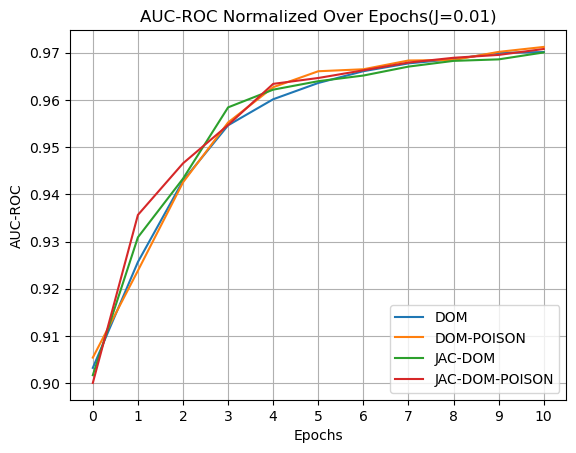

In [47]:
# subplot 2: the second subplot shows the development of the AUC-ROC value over the number of epochs (NORMALIZED AUC-ROC Score)

# Plot the AUC-ROC score
plt.plot(M1_aucroc_norm, label='DOM')
plt.plot(M2_aucroc_norm, label='DOM-POISON')
plt.plot(M3_aucroc_norm, label='JAC-DOM')
plt.plot(M4_aucroc_norm, label='JAC-DOM-POISON')
plt.xlabel('Epochs')
plt.ylabel('AUC-ROC')
plt.title('AUC-ROC Normalized Over Epochs (J=0.01)')
# plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.xticks(range(11))  # Set x-axis tick marks and labels, incrementing by 1
plt.grid(True)
plt.legend()
plt.show()

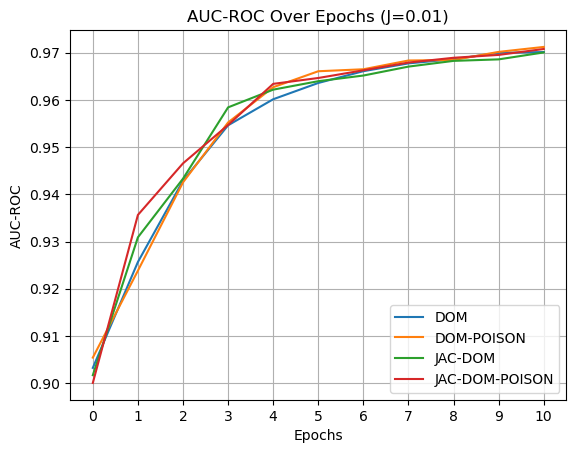

In [48]:
# subplot 3: the second subplot shows the development of the AUC-ROC value over the number of epochs (NOT-NORMALIZED AUC-ROC Score)

# Plot the AUC-ROC score
plt.plot(M1_aucroc_arr, label='DOM')
plt.plot(M2_aucroc_arr, label='DOM-POISON')
plt.plot(M3_aucroc_arr, label='JAC-DOM')
plt.plot(M4_aucroc_arr, label='JAC-DOM-POISON')
plt.xlabel('Epochs')
plt.ylabel('AUC-ROC')
plt.title('AUC-ROC Over Epochs (J=0.01)')
# plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.xticks(range(11))  # Set x-axis tick marks and labels, incrementing by 1
plt.grid(True)
plt.legend()
plt.show()

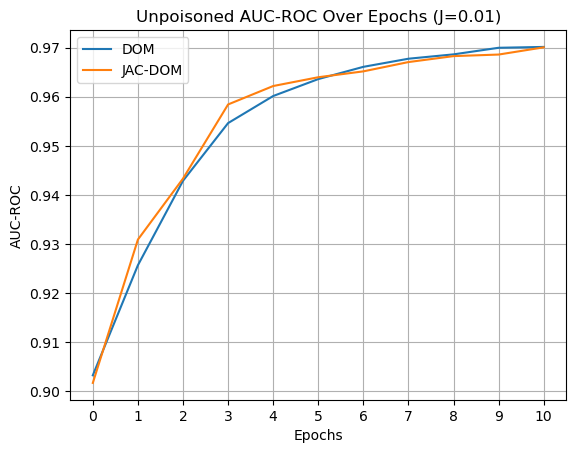

In [49]:

plt.plot(M1_aucroc_arr, label='DOM')
plt.plot(M3_aucroc_arr, label='JAC-DOM')
# plt.plot(M1_aucroc_norm, label='DOM-CLEAN AUC-ROC (norm)')
# plt.plot(M3_aucroc_norm, label='JAC-DOM-CLEAN AUC-ROC (norm)')
plt.xlabel('Epochs')
plt.ylabel('AUC-ROC')
plt.title('Unpoisoned AUC-ROC Over Epochs (J=0.01)')
# plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.xticks(range(11))  # Set x-axis tick marks and labels, incrementing by 1
plt.grid(True)
plt.legend()
plt.show()

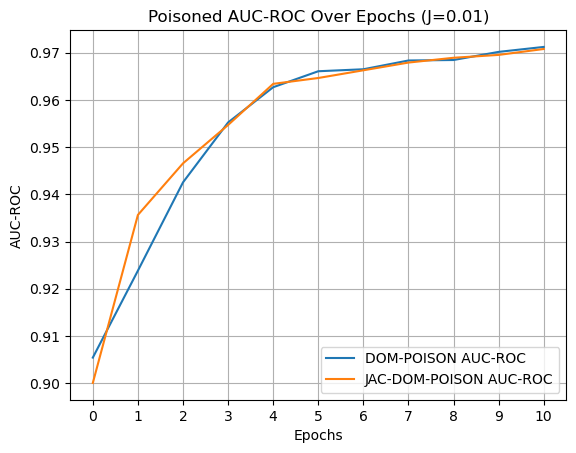

In [50]:

plt.plot(M2_aucroc_arr, label='DOM-POISON AUC-ROC')
plt.plot(M4_aucroc_arr, label='JAC-DOM-POISON AUC-ROC')

# plt.plot(M2_aucroc_norm, label='DOM-POISON AUC-ROC (norm)')
# plt.plot(M4_aucroc_norm, label='JAC-DOM-POISON AUC-ROC (norm)')

plt.xlabel('Epochs')
plt.ylabel('AUC-ROC')
plt.title('Poisoned AUC-ROC Over Epochs (J=0.01)')
# plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.xticks(range(11))  # Set x-axis tick marks and labels, incrementing by 1
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# from torch_geometric.datasets import Planetoid
# import torch_geometric.utils as pyg_utils
# import networkx as nx
# import matplotlib.pyplot as plt
# import torch

# import torch_geometric.transforms as T

# # Convert PyTorch Geometric data to NetworkX graph ---
# graph = pyg_utils.to_networkx(dataset, to_undirected=True)

# my_pos = nx.spring_layout(graph, seed = SEED)

# # Draws the graph ----
# plt.figure(figsize=(8, 8))
# nx.draw(graph, pos = my_pos, node_size=10, node_color='b', edge_color='gray', with_labels=False)
# plt.title('Facebook Dataset Graph')
# plt.show()

In [ ]:
# # make a train/validation/test split #
# labels = data.y

# # ----------- create new masks with specified split 
# split = [0.6, 0.2, 0.2]
# train_ratio = split[0]
# val_ratio = split[1]
# test_ratio = split[2]

# # Create a random permutation of node indices
# node_indices = torch.randperm(num_nodes)
# print(node_indices)

# # Calculate the split indices
# train_size = int(num_nodes * train_ratio)
# val_size = int(num_nodes * val_ratio)
# test_size = num_nodes - train_size - val_size

#     # Create new masks based on the split indices
# new_train_mask = torch.zeros(num_nodes, dtype=torch.bool)
# new_train_mask[node_indices[:train_size]] = True

# new_val_mask = torch.zeros(num_nodes, dtype=torch.bool)
# new_val_mask[node_indices[train_size:train_size+val_size]] = True

# new_test_mask = torch.zeros(num_nodes, dtype=torch.bool)
# new_test_mask[node_indices[train_size+val_size:]] = True

# # Assign the new masks to the data object
# data.train_mask = new_train_mask
# data.val_mask = new_val_mask
# data.test_mask = new_test_mask

# # Extract the new indices for the training, validation, and test sets
# idx_train = np.where(data.train_mask == True)[0]
# idx_val = np.where(data.val_mask == True)[0]
# idx_test = np.where(data.test_mask == True)[0]

# # from the RTGNN github ----------------------------------------------
# train_labels = labels[idx_train]
# val_labels = labels[idx_val]

# # Concatenating training and validation labels
# train_val_labels = np.concatenate([train_labels, val_labels],axis=0)

# # Concatenating training and validation masks
# idx = np.concatenate([idx_train, idx_val],axis=0)


# # # convert the T/F labels to integers --> used in the following call of "noisyfy_with_P"
# train_val_labels_int = train_val_labels.astype(int)
# # idx_int = idx.astype(int)